In [101]:
%matplotlib inline
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV

In [108]:
dpi = 175
fontsize = 10
plt.rc("savefig", dpi=dpi)
plt.rc('text', usetex=True)
plt.rc('font', size=fontsize)
plt.rc('xtick.major', pad=5)
plt.rc('xtick.minor', pad=5)
plt.rc('ytick.major', pad=5)
plt.rc('ytick.minor', pad=5)

# Load Data

In [2]:
data_dir = '/Users/nora/Box/dssg/DrivenData/Heart/data/'

In [3]:
test = pd.read_csv(data_dir + 'test_values.csv')
train = pd.read_csv(data_dir + 'train_values.csv')
labels = pd.read_csv(data_dir + 'train_labels.csv')

In [4]:
npatients = len(train)

# Prepare Data

In [5]:
def convert_columns(df, cols=[]):
    for col in cols:
        df[col] = df[col].astype(str)
    return df
        
def standardize(df, numeric_only=True):
    numeric = df.select_dtypes(include=['int64', 'float64'])
    
    # subtracy mean and divide by std
    df[numeric.columns] = (numeric - numeric.mean()) / numeric.std()
    
    return df

def pre_process_data(df, enforce_cols=None):
    print("Input shape:\t{}".format(df.shape))
        

    df = standardize(df)
    print("After standardization {}".format(df.shape))
        
    # create dummy variables for categoricals
    df = pd.get_dummies(df)
    print("After converting categoricals:\t{}".format(df.shape))
    

    # match test set and training set columns
    if enforce_cols is not None:
        to_drop = np.setdiff1d(df.columns, enforce_cols)
        to_add = np.setdiff1d(enforce_cols, df.columns)

        df.drop(to_drop, axis=1, inplace=True)
        df = df.assign(**{c: 0 for c in to_add})
    
    df.fillna(0, inplace=True)
    
    return df

## Prepare Train

In [6]:
patient_id = train['patient_id'].as_matrix()
train = train.drop('patient_id', axis=1)
train = convert_columns(train, cols=['chest_pain_type', 'resting_ekg_results'])
train = pre_process_data(train)

Input shape:	(180, 13)
After standardization (180, 13)
After converting categoricals:	(180, 20)


In [7]:
train.head()

,slope_of_peak_exercise_st_segment,resting_blood_pressure,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,thal_fixed_defect,thal_normal,thal_reversible_defect,chest_pain_type_1,chest_pain_type_2,chest_pain_type_3,chest_pain_type_4,resting_ekg_results_0,resting_ekg_results_1,resting_ekg_results_2
0,-0.888762,-0.194652,-0.716404,-0.437019,1.115158,-0.900694,0.670152,-1.051032,0.929891,-0.678852,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.727169,-1.252825,-0.716404,-0.437019,-0.667915,0.526148,-1.483908,-0.086892,0.386007,-0.678852,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,-0.888762,-0.371014,2.378462,-0.437019,1.039283,-0.900694,0.670152,2.377024,0.567302,1.464891,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,-0.888762,1.216246,-0.716404,-0.437019,-0.497195,-0.900694,0.670152,-1.586666,1.428452,-0.678852,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,2.343100,2.744719,-0.716404,-0.437019,0.394342,2.844768,0.670152,0.448742,-0.203201,-0.678852,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


## Prepare Labels

In [8]:
labels = np.ravel(labels.drop('patient_id', axis=1))

## Prepare Test

In [9]:
test_patient_id = test['patient_id'].as_matrix()
test = test.drop('patient_id', axis=1)
test = convert_columns(test, cols=['chest_pain_type', 'resting_ekg_results'])
test = pre_process_data(test)

Input shape:	(90, 13)
After standardization (90, 13)
After converting categoricals:	(90, 20)


## Split Data

In [10]:
train1, train2, labels1, labels2 = train_test_split(train, labels, train_size=0.75, test_size=0.25, shuffle=True)

# Prepare Submission

In [11]:
def prepare_submission(model, test, fname='submission.csv'):
    probs = model.predict_proba(test)
    sub = pd.DataFrame(np.vstack([test_patient_id, probs[:,1]]).T)
    sub.to_csv(fname, sep=',', header=['patient_id','heart_disease_present'], index=False)

In [12]:
def get_score(model, test, labels, printing=True):
    probs = model.predict_proba(test)
    preds = model.predict(test)
    if printing:
        print 'Accuracy: %.2f' %(model.score(test, labels)) # %(len(np.where(preds == labels))/len(preds))
        print 'Log loss: %.2f' %(log_loss(labels, probs))
    return log_loss(labels, probs)

# Extra Trees Classifier

In [13]:
# random forests are often a good model to try first, especially when we have numeric and categorical variables in our feature space.
def train_etc(features, labels, **kwargs):
    
    # instantiate model
    # model = RandomForestClassifier(n_estimators=50, random_state=0)
    model = ExtraTreesClassifier(n_estimators=50, random_state=0)
    
    # train model
    model.fit(features, labels)
    
    # get a (not-very-useful) sense of performance
    accuracy = model.score(features, labels)
    # print(f"In-sample accuracy: {accuracy:0.2%}")
    # print("In-sample accuracy: %.2f percent" %(accuracy*100))
    
    return model

In [14]:
model = train_etc(train1, labels1)

In [15]:
preds = model.predict(train2)
probs = model.predict_proba(train2)

In [16]:
print 'Accuracy: %.2f' %(model.score(train2, labels2))
print 'Log loss: %.2f' %(log_loss(labels2, probs))

Accuracy: 0.80
Log loss: 1.09


In [17]:
model = train_etc(train, labels)

In [18]:
probs = model.predict_proba(test)
preds = model.predict(test)

In [19]:
sub = pd.DataFrame(np.vstack([test_patient_id, probs[:,1]]).T)

In [20]:
sub.to_csv('submission1.csv', sep=',', header=['patient_id','heart_disease_present'], index=False)

In [21]:
prepare_submission(model, test, 'submission.csv')

# Visualize Score

In [103]:
def plot_results(labels, probs, thresh=0.5):
    plt.figure(figsize=(3,3))
    plt.scatter(labels, probs[:,1], edgecolor='none', c='cornflowerblue', s=40, alpha=0.5)
    plt.axhline(thresh, c='grey', alpha=0.2, lw=2, zorder=0, ls='--')
    plt.xlabel('True Classification')
    plt.ylabel('Model Probability')
    plt.title('log loss = %.2f'%log_loss(labels, probs))
    plt.xticks([0,1])
    plt.xlim(-0.5, 1.5)
    plt.show()
    
    
    fpr, tpr, thresh = roc_curve(labels2, probs[:,1])
    
    plt.figure(figsize=(3,3))
    plt.plot(fpr, tpr, 'cornflowerblue', lw=3)
    plt.xlabel('False Positives')
    plt.ylabel('True Positives')
    plt.title('ROC Curve')
    plt.xlim(-0.1,1.1)
    plt.ylim(-0.1,1.1)
    plt.grid()
    plt.show()

In [104]:
model = train_etc(train1, labels1)

In [105]:
probs = model.predict_proba(train2)
preds = model.predict(train2)

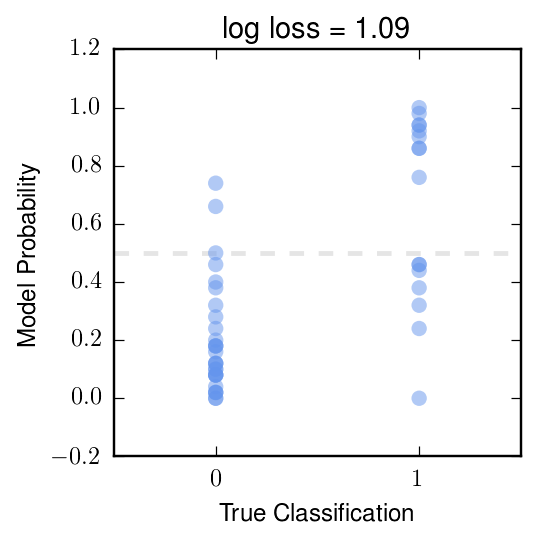

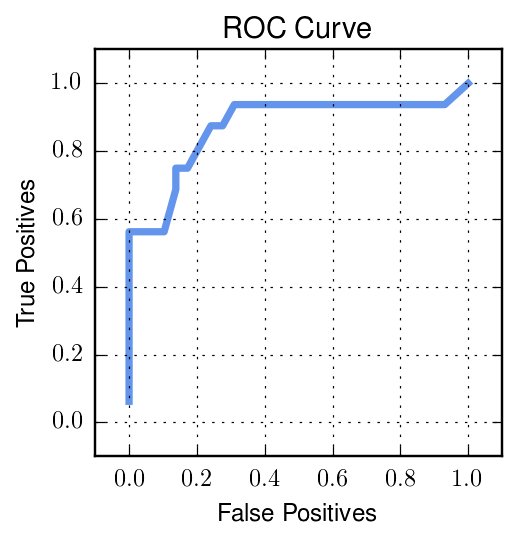

In [109]:
plot_results(labels2, probs)

In [115]:
ext = ExtraTreesClassifier(n_jobs=2)
params = {'n_estimators':[10, 20, 50, 100, 200], 'criterion':['gini', 'entropy'], 'min_samples_split':[2, 3, 4, 5]}

In [116]:
ext_gs = GridSearchCV(ext, params, cv=10, return_train_score=True)
ext_gs.fit(train, labels)

GridSearchCV(cv=10, error_score='raise',
       estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 20, 50, 100, 200], 'min_samples_split': [2, 3, 4, 5], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [122]:
print 'Best params: ', ext_gs.best_params_
best_ext = ext_gs.best_estimator_

Best params:  {'min_samples_split': 3, 'n_estimators': 100, 'criterion': 'gini'}


In [124]:
prepare_submission(best_ext, test, fname='submission_ext_cv.csv')